In [15]:
# packages
import numpy as np 
import matplotlib.pyplot as plt
import os
from scipy import integrate
from scipy.stats import norm

import astropy.coordinates as coord
import astropy.units as u
from scipy import integrate, optimize

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# graphic parameters
plt.rcParams['font.size'] = 13
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.rcParams['axes.linewidth']  = 1.4
plt.rcParams['figure.figsize']  = (8, 4)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 1.8
plt.rcParams['ytick.major.width'] = 1.8   
plt.rcParams['lines.markeredgewidth'] = 2

# defining a numpy seed for random
np.random.seed(0)

# creating a folder to save the plots
pltpath = 'plots/'
if not os.path.exists(pltpath):
    os.makedirs(pltpath)
dpi      = 400     # resolution of saved images

# ----- some constants ----- #
G     = 6.6743e-8     # gravitational constant
kb    = 1.3807e-16    # Boltzmann constant
sigma = 5.67e-5       # Stefan-Boltzmann constant
Msun  = 1.9884e33     # sun mass
Rsun  = 6.957e10      # sun radius
m_H   = 1.6726e-24    # mass of the proton/hydrogen
m_e   = 9.1094e-28    # mass of the electron
c     = 2.9979e10     # speed of light
Na    = 6.022140e22   # avogadro number
aRad  = 7.5657e-15    # radiation constant
hPl   = 6.6261e-27    # planck constant
ech   = 4.8032e-10    # electron charge
hbar  = 1.0546e-27

In [2]:
c1 = (0/255,0/255,0/255)
c2 = (0/255,246/255,255/255)
c3 = (243/255,0/255,255/255)

predC = [c1, c2, c3]

def color_gen(x, COLORS=predC):
    
    C1, C2, C3 = COLORS[0], COLORS[1], COLORS[2]
    
    if x >= 0 and x <= 1/2:
        xeff = x
        r = C1[0] * (1 - 2 * xeff) + C2[0] * 2 * xeff
        g = C1[1] * (1 - 2 * xeff) + C2[1] * 2 * xeff
        b = C1[2] * (1 - 2 * xeff) + C2[2] * 2 * xeff
    elif x > 1/2 and x <= 1:
        xeff = x - 1/2
        r = C2[0] * (1 - 2 * xeff) + C3[0] * 2 * xeff
        g = C2[1] * (1 - 2 * xeff) + C3[1] * 2 * xeff
        b = C2[2] * (1 - 2 * xeff) + C3[2] * 2 * xeff
    else:
        print('Input should be in range [0 , 1]')
        
    return (r, g, b)

def quadratic_linspace(start, end, num, factor=2):
    """
    Generate a quadratic sequence of numbers between start and end, with num points.
    """
    a = (end - start) / (num - 1)**factor
    x = np.arange(num)
    y = a * x**factor + start
    return y

def exponential_linspace(start, end, num, factor=2):
    """
    Generate an exponential sequence of numbers between start and end, with num points.
    """
    a = np.log(end / start) / (num - 1)**factor
    x = np.arange(num)
    y = start * np.exp(a * x**factor)
    return y

def double_gauss(x, A, mu, sigma, B):
    return A * (norm.pdf(x, -mu, sigma) + norm.pdf(x, mu, sigma)) + B

In [3]:
nreps = 7000
xmax  = 0.2

angle     = np.deg2rad(exponential_linspace(0.2, 1.5, nreps, 0.9))
altitudes = np.linspace(30, 0, nreps, endpoint=False)

x = [np.linspace(-xmax, xmax, 500) for _ in range(nreps)]
y = [-np.abs(np.tan(np.pi/2 - angle[i]) * x[i]) + altitudes[i] for i in range(nreps)]

for i in range(nreps):
    mask = y[i] >= 0

    x[i] = x[i][mask]
    y[i] = y[i][mask]
    

xsample = []
for i in range(nreps):
    if len(x[i]) > 0:
        xsample.append(x[i][0])
        xsample.append(x[i][-1])
        
nbins = 60
xmax  = 0.2
xbins = np.linspace(-xmax, xmax, nbins)
xbinsc = xbins[:-1] + np.diff(xbins) / 2
datahist, _ = np.histogram(xsample, bins=xbins)

datahist[5], datahist[-6] = 700, 700
datahist[4], datahist[-5] = 300, 300
datahist[3], datahist[-4] = 150, 150
datahist[2], datahist[-3] = 80, 80
datahist[1], datahist[-2] = 30, 30
datahist[0], datahist[-1] = 30, 30

datahist[7], datahist[-8] = 1039, 1039

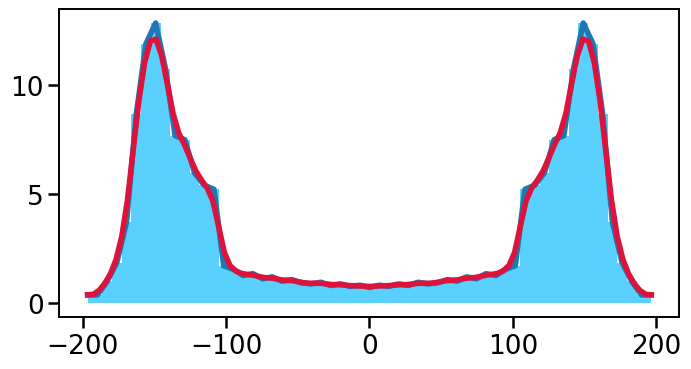

In [4]:
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

def smooth_and_interpolate(x, y, sigma=2, num_points=200):
    # Apply Gaussian smoothing to the y-values
    smoothed_y = gaussian_filter1d(y, sigma)

    # Interpolate the smoothed data
    interp_func = interp1d(x, smoothed_y, kind='cubic')
    new_x = np.linspace(x[0], x[-1], num=num_points)
    new_y = interp_func(new_x)

    return new_x, new_y


hist = datahist/sum(datahist)*200

new_x, new_y = smooth_and_interpolate(xbinsc*1e3, hist, sigma=0.7, num_points=100)

plt.fill_between(xbinsc*1e3, hist, step='mid', zorder=-10, color=color_gen(0.6), alpha=.8, edgecolor='k', lw=0, label='ground light dist.')
plt.plot(xbinsc*1e3, hist)
    
plt.plot(new_x, new_y, color='crimson')

In [5]:
nreps = 15
xmax  = 0.2

angle     = np.deg2rad(exponential_linspace(0.2, 1.5, nreps, 0.9))
altitudes = np.linspace(30, 0, nreps, endpoint=False)

x = [np.linspace(-xmax, xmax, 500) for _ in range(nreps)]
y = [-np.abs(np.tan(np.pi/2 - angle[i]) * x[i]) + altitudes[i] for i in range(nreps)]

for i in range(nreps):
    mask = y[i] >= 0

    x[i] = x[i][mask]
    y[i] = y[i][mask]
    

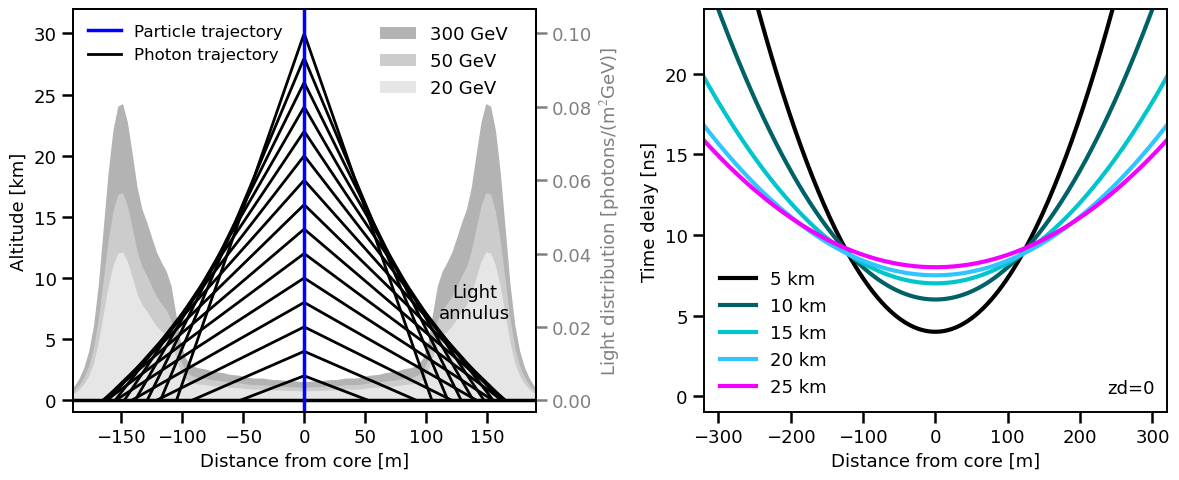

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]})

for i in range(nreps):
    ax1.plot(x[i]*1e3, y[i], lw=2, color='k')

hist = datahist/sum(datahist)*200

    
ax1.axhline(0, color='k', lw=2.5)
ax1.axvline(0, color='b', lw=2.5, label='Particle trajectory', linewidth=4)
    
ax1.text(140, 8, 'Light\nannulus', ha='center', va='center', color='k') #color_gen(0.6))
# ax1.annotate('', xy=(165,20), xytext=(100,20), arrowprops=dict(arrowstyle='<->', lw=2))

ax1.plot([], [], lw=2, color='k', label='Photon trajectory')
ax1.legend(loc=2, fontsize=12, frameon=False)
ax1.set_ylim(-1, 32)
ax1.set_xlim(-190,190)
ax1.set_xlabel('Distance from core [m]')
ax1.set_ylabel('Altitude [km]')

xx = np.linspace(-400, 400, 300) 
ax2.plot(xx, 1e-3*xx**2/3 + 4, color=color_gen(0), label='5 km', lw=3)
ax2.plot(xx, 1e-3*xx**2/5 + 6, color=color_gen(.2), label='10 km', lw=3)
ax2.plot(xx, 1e-3*xx**2/8 + 7, color=color_gen(.4), label='15 km', lw=3)
ax2.plot(xx, 1e-3*xx**2/11 + 7.5, color=color_gen(.6), label='20 km', lw=3)
ax2.plot(xx, 1e-3*xx**2/13 + 8, color=color_gen(1), label='25 km', lw=3)

ax2.legend(frameon=False)
ax2.set_ylim(-1, 24)
ax2.set_xlim(-320, 320)
ax2.set_xlabel('Distance from core [m]')
ax2.set_ylabel('Time delay [ns]')




ax1t = ax1.twinx()
# ax1t.plot(x, y2, 'b-')
ax1t.set_ylabel('Light distribution [photons/(m${}^2$GeV)]', color='gray')
ax1t.tick_params('y', colors='gray')


ff = 0.01/3

ax1t.fill_between(new_x, new_y*2*ff, zorder=-100, color='0.7', alpha=1, edgecolor='k', lw=0, label='300 GeV  ')
ax1t.fill_between(new_x, new_y*1.4*ff, zorder=-100, color='0.8', alpha=1, edgecolor='k', lw=0, label='50 GeV ')
ax1t.fill_between(new_x, new_y*ff, zorder=-100, color='0.9', alpha=1, edgecolor='k', lw=0, label='20 GeV ')

ax1t.set_ylim(-1*ff, 32*ff)
ax1t.legend(loc=1, frameon=False)

ax1.set_zorder(ax1t.get_zorder()+1)
ax1.patch.set_visible(False)
ax2.text(270, 0.5, 'zd=0', fontsize=13, ha='center', va='center')


plt.tight_layout()

plt.savefig(f'{pltpath}cherenkov_shower_morphology.pdf', bbox_inches='tight', dpi=dpi)
plt.show()